# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# disable tensorflow log level infos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # show only errors

import sys
import pandas as pd

if '../../../../notebooks/' not in sys.path:
    sys.path.append('../../../../notebooks/')
if 'src' not in sys.path:
    sys.path.insert(0, 'src')

import utils.constants as cts

from data_loaders.data_loader import DLName
from gt_loaders.gt_names import GTName
from exp_runner import ExperimentRunner
from base.model_evaluator import DataSource, DataPredSelection
from base.base_models import BaseModel
from base.optimizers import Optimizer
from base.model_creator import MTLApproach, NAS_MTLApproach

 ==> Restrict GPU memory growth: True


# Start Network runner

In [3]:
kwargs = { 
    'use_neptune': True,
    'exp_params' : {
        'name': 'neural_arch_search',
        'description': 'Making NAS with APPROACH_1 (random) and training best architecture for 50 epochs to evaluate on test set',
        'tags': ['ground truths', 'nas', 'nas_approach_1'],
        'src_files': ["src/**/*.py"]
    },
    'properties': {
        'approach': NAS_MTLApproach.APPROACH_1,
        'reqs': list(cts.ICAO_REQ),
        'aligned': False,
        'use_gt_data': True,
        'gt_names': {
            'train_validation': [],
            'test': [],
            'train_validation_test': [GTName.FVC]
        },
        'balance_input_data': False,
        'train_model': False,
        'save_trained_model': True,
        'exec_nas': False,
        'orig_model_experiment_id': 'ICAO-265',
        'sample_training_data': False,
        'sample_prop': 1.0
    },
    'net_train_params': {
        'base_model': BaseModel.VGG16,
        'batch_size': 32,
        'n_epochs': 50,
        'early_stopping': 99,
        'learning_rate': 1e-3,
        'optimizer': Optimizer.ADAMAX,
        'dropout': 0.3
    },
    'nas_params': {
        'max_blocks_per_branch': 5,
        'n_epochs': 5,
        'n_trials': 30
    }
}

runner = ExperimentRunner(**kwargs)

-------------------- Init ExperimentRunner -------------------
---------------------------
Parent Process ID: 71660
Process ID: 583231
---------------------------
-----
Use Neptune:  True
-----
-------------------
Args: 
{'exp_params': {'description': 'Making NAS with APPROACH_1 (random) and '
                               'training best architecture for 50 epochs to '
                               'evaluate on test set',
                'name': 'neural_arch_search',
                'src_files': ['src/**/*.py'],
                'tags': ['ground truths', 'nas', 'nas_approach_1']},
 'nas_params': {'max_blocks_per_branch': 5, 'n_epochs': 5, 'n_trials': 30},
 'net_train_params': {'base_model': <BaseModel.VGG16: {'target_size': (224, 224), 'prep_function': <function preprocess_input at 0x7fec642e44c0>}>,
                      'batch_size': 32,
                      'dropout': 0.3,
                      'early_stopping': 99,
                      'learning_rate': 0.001,
                   

# Load Data

In [4]:
runner.load_training_data()

-------------------- load training data -------------------
Loading data
Loading GT FVC - TRAIN split...
..Ignoring 0 empty label values
Input data.shape: (4928, 26)
Loading GT FVC - VALIDATION split...
..Ignoring 0 empty label values
Input data.shape: (547, 26)
Loading GT FVC - TEST split...
..Ignoring 0 empty label values
Input data.shape: (288, 26)
Data loaded


# Data Generators

In [5]:
runner.setup_data_generators()

-------------------- setup data generators -------------------
Starting data generators
Found 4928 validated image filenames.
Found 547 validated image filenames.
Found 288 validated image filenames.
TOTAL: 5763

Logging class indices
 .. MTL model not logging class indices!

Logging class labels
 COMPLIANT label: 1
 NON_COMPLIANT label: 0
 DUMMY label: -1
 DUMMY_CLS label: 2
 NO_ANSWER label: -99


# Setup Experiment

In [6]:
runner.setup_experiment()

-------------------- create experiment -------------------
Setup neptune properties and parameters
Properties and parameters setup done!


# Labels Distribution

In [7]:
%%capture
runner.summary_labels_dist()

# Neural Architecture Search

In [8]:
runner.run_neural_architeture_search()

-------------------- run neural architecture search -------------------
Not executing neural architecture search
 ..Experiment ID: ICAO-265
 ..Downloading data from previous experiment
https://ui.neptune.ai/guilhermemg/icao-nets-training-2/e/ICAO-265
  ...fetching data from previous trials
  ...fetching data from best trial
 ..Data uploaded to current experiment


# Create Model

In [9]:
best_config = {'n_denses_0': 5, 'n_denses_1': 1, 'n_denses_2': 4, 'n_denses_3': 5}
runner.create_model(best_config)

-------------------- create model -------------------
Creating model...
Model created


# Vizualize Model

-------------------- vizualize model -------------------


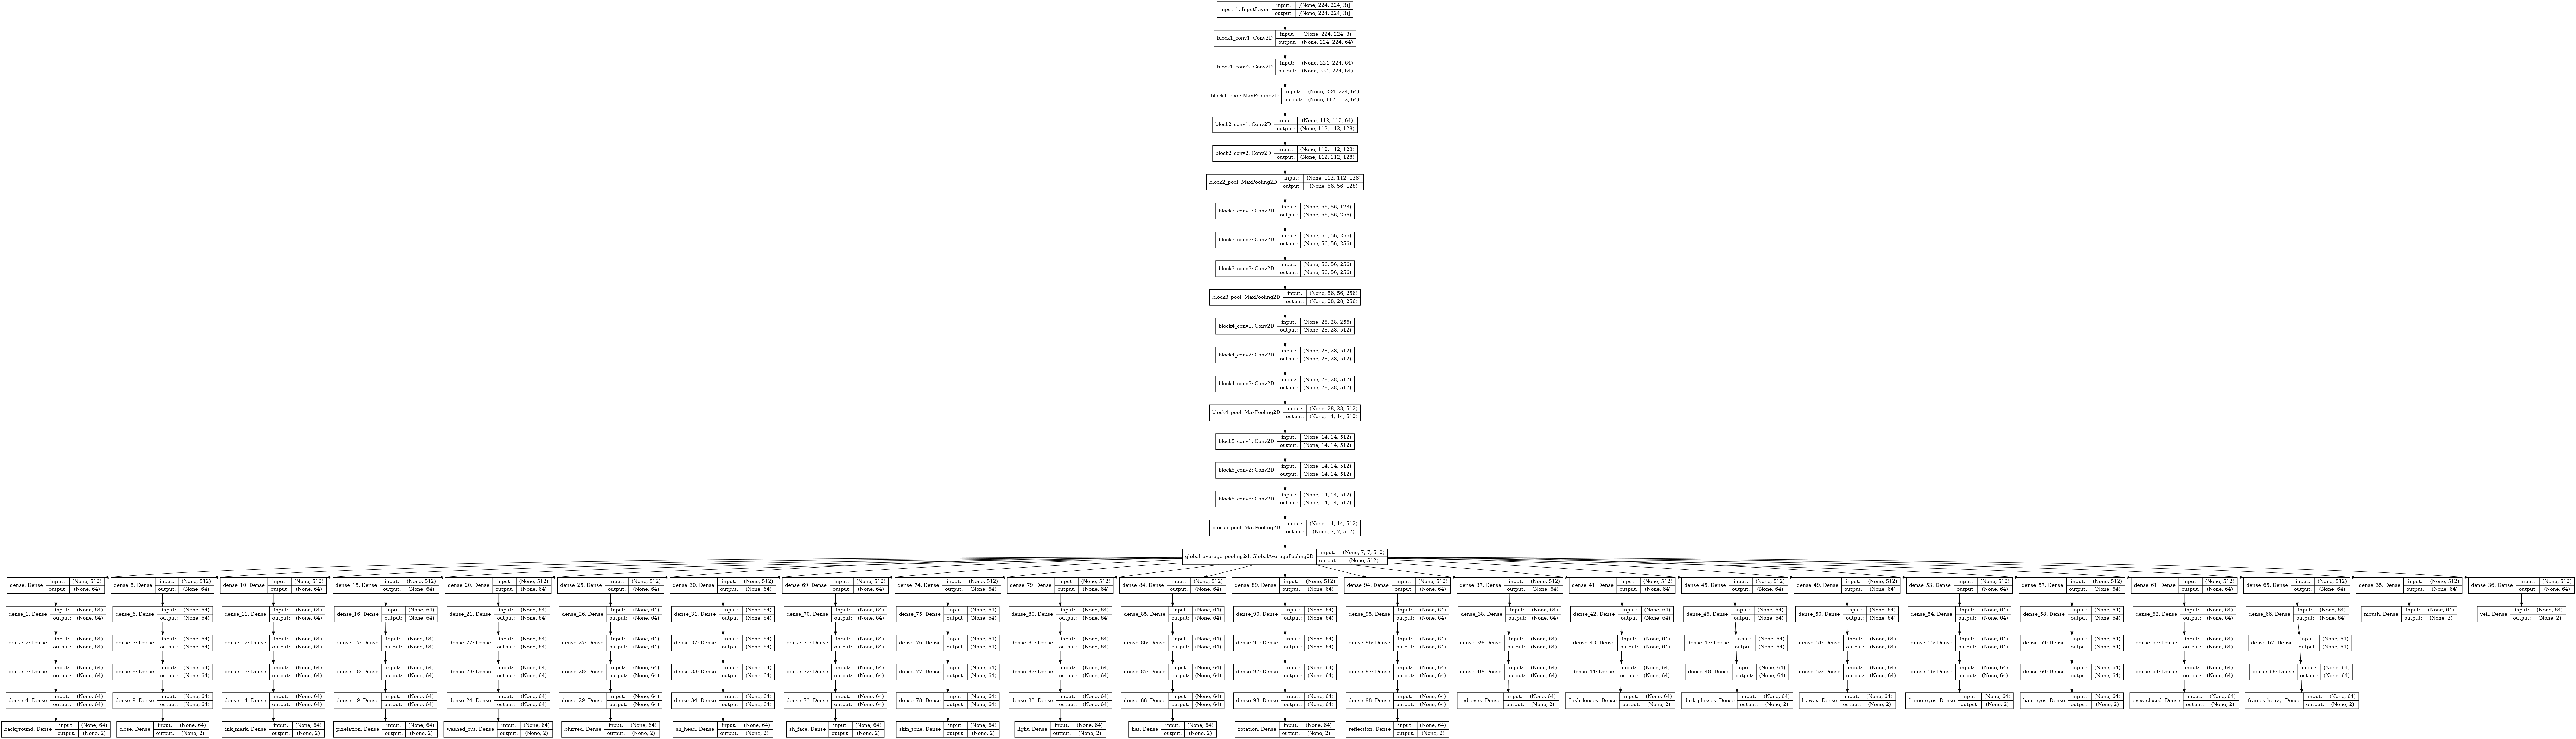

In [10]:
runner.visualize_model(outfile_path=f"figs/nas/nas_model_approach_1.png")

In [11]:
%%capture
runner.model_summary()

# Training Model

In [12]:
runner.train_model()

-------------------- train model -------------------
Not training a model. Downloading data from Neptune
 ..Experiment ID: ICAO-265
 ..Downloading data from previous experiment
https://ui.neptune.ai/guilhermemg/icao-nets-training-2/e/ICAO-265
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..Download finished
 ..Upload data to current experiment
 ..

# Plots

In [13]:
runner.draw_training_history()

-------------------- draw training history -------------------
Not training a model. Downloading plot from Neptune
 ..Experiment ID: ICAO-265
 ..Downloading plot from previous experiment
https://ui.neptune.ai/guilhermemg/icao-nets-training-2/e/ICAO-265
 ..Download finished
 ..Uploading plot
 ..Upload finished


# Load Best Model

In [14]:
runner.load_best_model()

-------------------- load best model -------------------
..Loading best model
..Model loaded
...Model path: prev_trained_models/multi_task/fvc_not_aligned/multi_reqs/ICAO-265


# Saving Trained Model

In [15]:
runner.save_model()

-------------------- save model -------------------
Saving model
INFO:tensorflow:Assets written to: prev_trained_models/multi_task/fvc_not_aligned/multi_reqs/ICAO-265/assets
..Model saved
...Model path: prev_trained_models/multi_task/fvc_not_aligned/multi_reqs/ICAO-265
Saving model to neptune
 ..Uploading file trained_model.zip
Model saved into Neptune
Saving process finished


# Test Trained Model

## Validation Split

Testing Trained Model
Predicting labels....
18/18 [==============================] - 38s 2s/step
Prediction finished!
Requisite: MOUTH


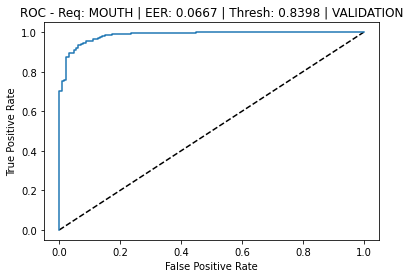

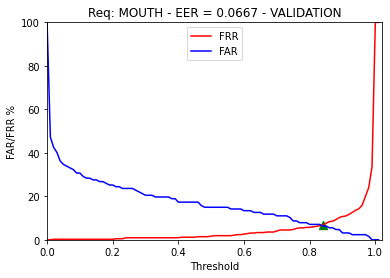

Requisite: MOUTH - EER_interp: 6.67% - Best Threshold: 0.8398388425509135
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.81      0.94      0.87       127
    COMPLIANT       0.98      0.93      0.96       420

     accuracy                           0.93       547
    macro avg       0.89      0.94      0.91       547
 weighted avg       0.94      0.93      0.94       547

Confusion matrix ----------------------------------------
FAR: 6.3% | FRR: 6.67% | EER_mean: 6.4799999999999995% | TP: 392 | TN: 119 | FP: 8 | FN: 28
Accuracy ------------------------------------------------
Model Accuracy: 93.42%
---------------------------------------------------------
Requisite: ROTATION


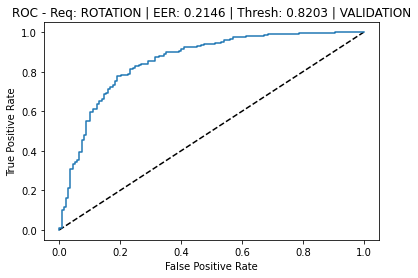

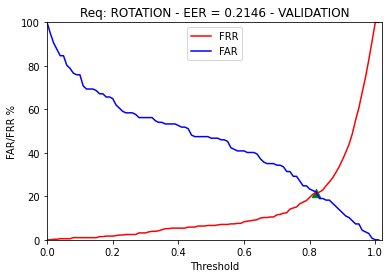

Requisite: ROTATION - EER_interp: 21.46% - Best Threshold: 0.820302030952974
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.55      0.79      0.65       137
    COMPLIANT       0.92      0.79      0.85       410

     accuracy                           0.79       547
    macro avg       0.73      0.79      0.75       547
 weighted avg       0.83      0.79      0.80       547

Confusion matrix ----------------------------------------
FAR: 21.17% | FRR: 21.46% | EER_mean: 21.32% | TP: 322 | TN: 108 | FP: 29 | FN: 88
Accuracy ------------------------------------------------
Model Accuracy: 78.61%
---------------------------------------------------------
Requisite: L_AWAY


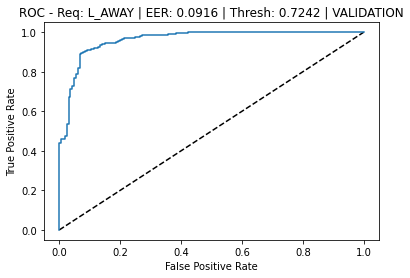

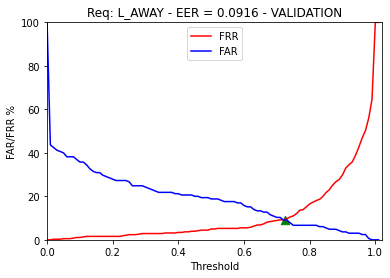

Requisite: L_AWAY - EER_interp: 9.16% - Best Threshold: 0.7241805367442786
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.81      0.91      0.86       165
    COMPLIANT       0.96      0.91      0.93       382

     accuracy                           0.91       547
    macro avg       0.88      0.91      0.89       547
 weighted avg       0.91      0.91      0.91       547

Confusion matrix ----------------------------------------
FAR: 9.09% | FRR: 9.16% | EER_mean: 9.120000000000001% | TP: 347 | TN: 150 | FP: 15 | FN: 35
Accuracy ------------------------------------------------
Model Accuracy: 90.86%
---------------------------------------------------------
Requisite: EYES_CLOSED


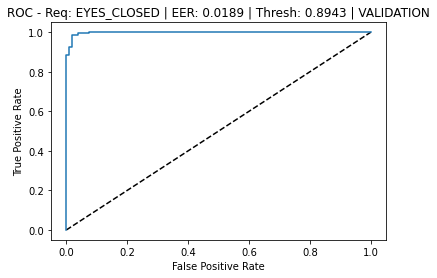

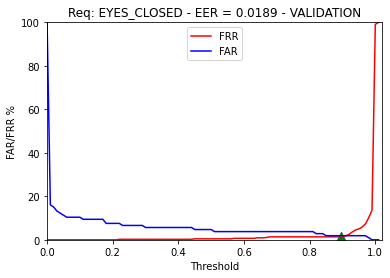

Requisite: EYES_CLOSED - EER_interp: 1.8900000000000001% - Best Threshold: 0.8942891359304344
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.95      0.98      0.96       106
    COMPLIANT       1.00      0.99      0.99       441

     accuracy                           0.99       547
    macro avg       0.97      0.98      0.98       547
 weighted avg       0.99      0.99      0.99       547

Confusion matrix ----------------------------------------
FAR: 1.8900000000000001% | FRR: 1.3599999999999999% | EER_mean: 1.6199999999999999% | TP: 435 | TN: 104 | FP: 2 | FN: 6
Accuracy ------------------------------------------------
Model Accuracy: 98.54%
---------------------------------------------------------
Requisite: CLOSE


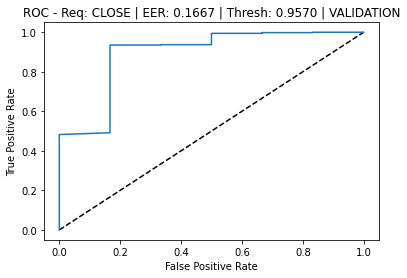

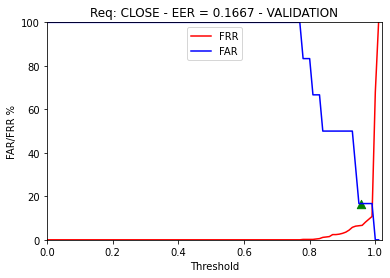

Requisite: CLOSE - EER_interp: 16.669999999999998% - Best Threshold: 0.9570168852805405
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.12      0.83      0.22         6
    COMPLIANT       1.00      0.94      0.97       541

     accuracy                           0.93       547
    macro avg       0.56      0.88      0.59       547
 weighted avg       0.99      0.93      0.96       547

Confusion matrix ----------------------------------------
FAR: 16.669999999999998% | FRR: 6.47% | EER_mean: 11.57% | TP: 506 | TN: 5 | FP: 1 | FN: 35
Accuracy ------------------------------------------------
Model Accuracy: 93.42%
---------------------------------------------------------
Requisite: HAT


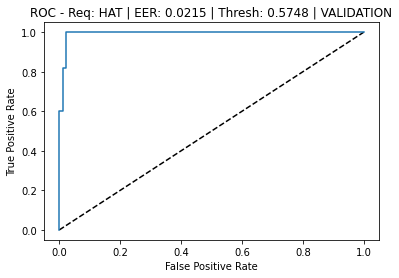

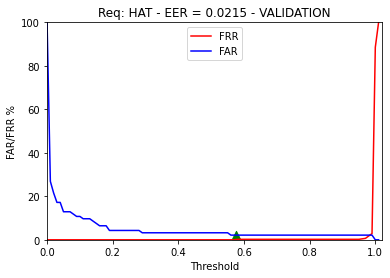

Requisite: HAT - EER_interp: 2.15% - Best Threshold: 0.574806869029634
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       1.00      0.98      0.99        93
    COMPLIANT       1.00      1.00      1.00       454

     accuracy                           1.00       547
    macro avg       1.00      0.99      0.99       547
 weighted avg       1.00      1.00      1.00       547

Confusion matrix ----------------------------------------
FAR: 2.15% | FRR: 0.0% | EER_mean: 1.0699999999999998% | TP: 454 | TN: 91 | FP: 2 | FN: 0
Accuracy ------------------------------------------------
Model Accuracy: 99.63%
---------------------------------------------------------
Requisite: DARK_GLASSES


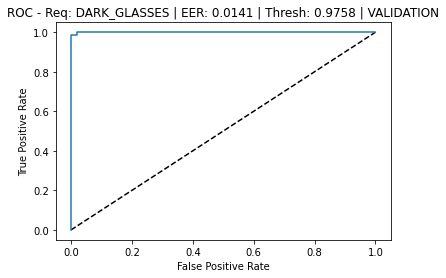

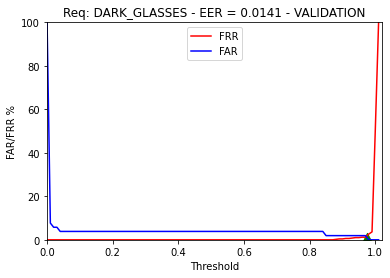

Requisite: DARK_GLASSES - EER_interp: 1.41% - Best Threshold: 0.9758180169144067
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.88      1.00      0.94        52
    COMPLIANT       1.00      0.99      0.99       495

     accuracy                           0.99       547
    macro avg       0.94      0.99      0.96       547
 weighted avg       0.99      0.99      0.99       547

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 1.41% | EER_mean: 0.7000000000000001% | TP: 488 | TN: 52 | FP: 0 | FN: 7
Accuracy ------------------------------------------------
Model Accuracy: 98.72%
---------------------------------------------------------
Requisite: FRAMES_HEAVY


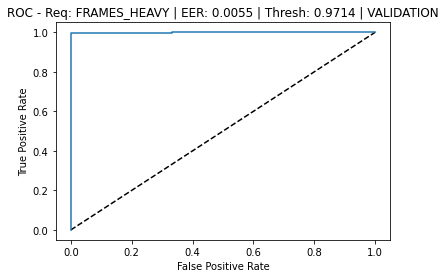

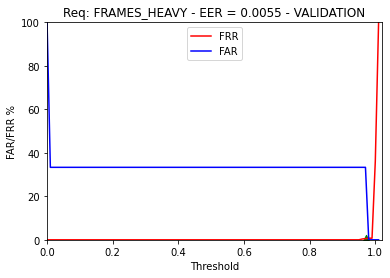

Requisite: FRAMES_HEAVY - EER_interp: 0.5499999999999999% - Best Threshold: 0.9714042112669524
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.50      1.00      0.67         3
    COMPLIANT       1.00      0.99      1.00       544

     accuracy                           0.99       547
    macro avg       0.75      1.00      0.83       547
 weighted avg       1.00      0.99      1.00       547

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 0.5499999999999999% | EER_mean: 0.27999999999999997% | TP: 541 | TN: 3 | FP: 0 | FN: 3
Accuracy ------------------------------------------------
Model Accuracy: 99.45%
---------------------------------------------------------
Requisite: FRAME_EYES


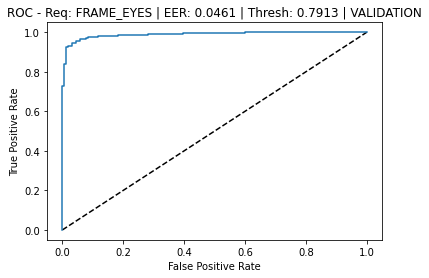

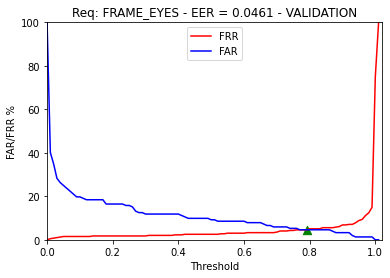

Requisite: FRAME_EYES - EER_interp: 4.61% - Best Threshold: 0.7912774681988539
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.89      0.95      0.92       152
    COMPLIANT       0.98      0.95      0.97       395

     accuracy                           0.95       547
    macro avg       0.94      0.95      0.94       547
 weighted avg       0.96      0.95      0.95       547

Confusion matrix ----------------------------------------
FAR: 4.61% | FRR: 4.5600000000000005% | EER_mean: 4.58% | TP: 377 | TN: 145 | FP: 7 | FN: 18
Accuracy ------------------------------------------------
Model Accuracy: 95.43%
---------------------------------------------------------
Requisite: FLASH_LENSES


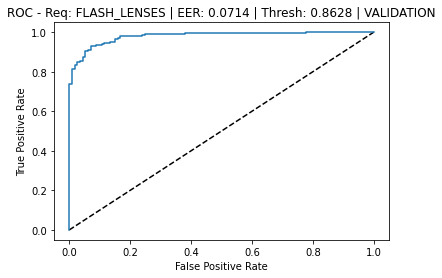

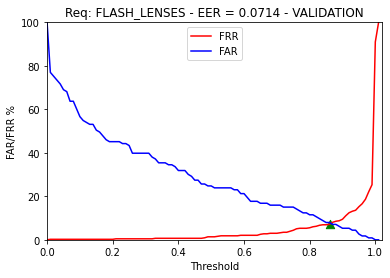

Requisite: FLASH_LENSES - EER_interp: 7.140000000000001% - Best Threshold: 0.8628394561154356
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.77      0.93      0.84       113
    COMPLIANT       0.98      0.93      0.95       434

     accuracy                           0.93       547
    macro avg       0.88      0.93      0.90       547
 weighted avg       0.94      0.93      0.93       547

Confusion matrix ----------------------------------------
FAR: 7.08% | FRR: 7.140000000000001% | EER_mean: 7.109999999999999% | TP: 403 | TN: 105 | FP: 8 | FN: 31
Accuracy ------------------------------------------------
Model Accuracy: 92.86999999999999%
---------------------------------------------------------
Requisite: VEIL


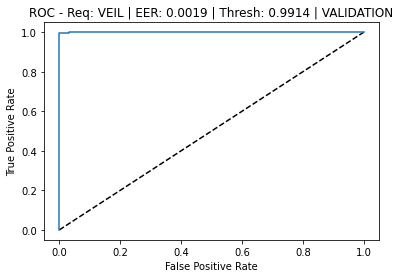

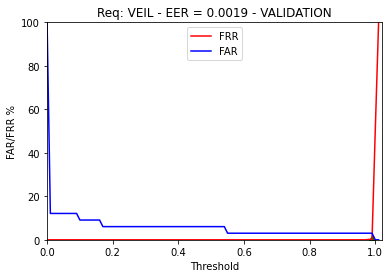

Requisite: VEIL - EER_interp: 0.19% - Best Threshold: 0.9913733361528078
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.97      1.00      0.99        33
    COMPLIANT       1.00      1.00      1.00       514

     accuracy                           1.00       547
    macro avg       0.99      1.00      0.99       547
 weighted avg       1.00      1.00      1.00       547

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 0.19% | EER_mean: 0.1% | TP: 513 | TN: 33 | FP: 0 | FN: 1
Accuracy ------------------------------------------------
Model Accuracy: 99.82%
---------------------------------------------------------
Requisite: REFLECTION


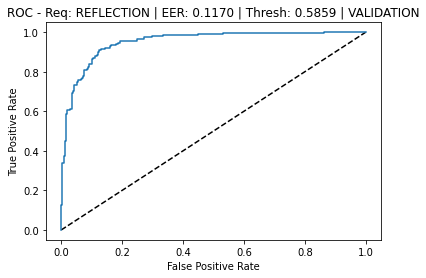

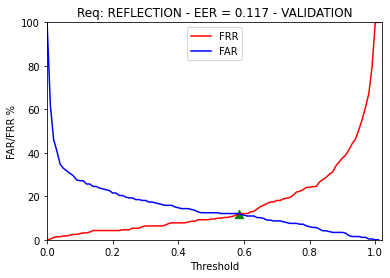

Requisite: REFLECTION - EER_interp: 11.700000000000001% - Best Threshold: 0.5858806669711407
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.88      0.88      0.88       265
    COMPLIANT       0.89      0.88      0.89       282

     accuracy                           0.88       547
    macro avg       0.88      0.88      0.88       547
 weighted avg       0.88      0.88      0.88       547

Confusion matrix ----------------------------------------
FAR: 11.700000000000001% | FRR: 11.700000000000001% | EER_mean: 11.700000000000001% | TP: 249 | TN: 234 | FP: 31 | FN: 33
Accuracy ------------------------------------------------
Model Accuracy: 88.3%
---------------------------------------------------------
Requisite: LIGHT


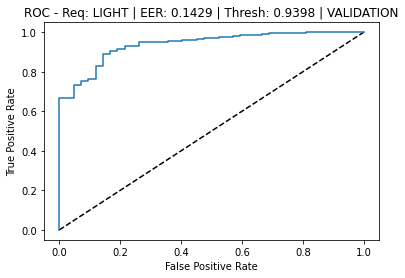

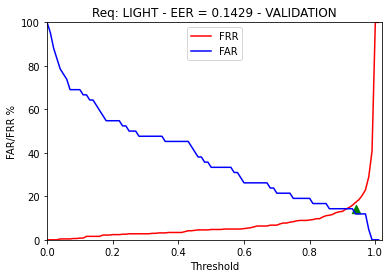

Requisite: LIGHT - EER_interp: 14.29% - Best Threshold: 0.9398370981216588
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.29      0.86      0.44        42
    COMPLIANT       0.99      0.83      0.90       505

     accuracy                           0.83       547
    macro avg       0.64      0.84      0.67       547
 weighted avg       0.93      0.83      0.86       547

Confusion matrix ----------------------------------------
FAR: 14.29% | FRR: 17.23% | EER_mean: 15.76% | TP: 418 | TN: 36 | FP: 6 | FN: 87
Accuracy ------------------------------------------------
Model Accuracy: 83.0%
---------------------------------------------------------
Requisite: SH_FACE


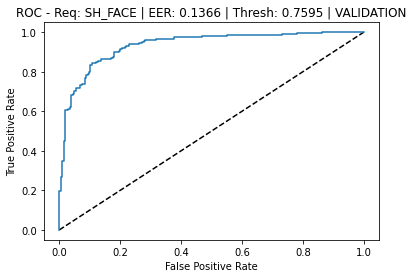

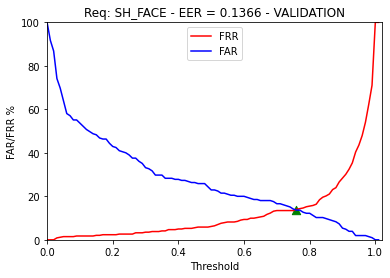

Requisite: SH_FACE - EER_interp: 13.66% - Best Threshold: 0.7594643235202565
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.79      0.86      0.83       205
    COMPLIANT       0.91      0.87      0.89       342

     accuracy                           0.86       547
    macro avg       0.85      0.86      0.86       547
 weighted avg       0.87      0.86      0.87       547

Confusion matrix ----------------------------------------
FAR: 13.66% | FRR: 13.450000000000001% | EER_mean: 13.56% | TP: 296 | TN: 177 | FP: 28 | FN: 46
Accuracy ------------------------------------------------
Model Accuracy: 86.47%
---------------------------------------------------------
Requisite: SH_HEAD


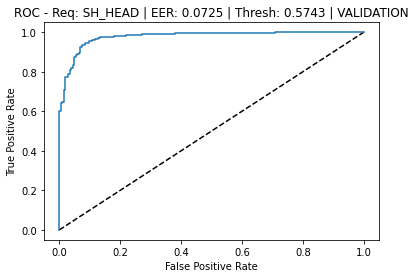

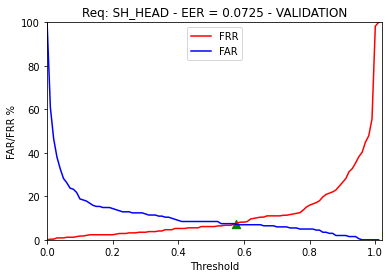

Requisite: SH_HEAD - EER_interp: 7.249999999999999% - Best Threshold: 0.5743342646654088
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.88      0.93      0.91       202
    COMPLIANT       0.96      0.93      0.94       345

     accuracy                           0.93       547
    macro avg       0.92      0.93      0.92       547
 weighted avg       0.93      0.93      0.93       547

Confusion matrix ----------------------------------------
FAR: 6.93% | FRR: 7.249999999999999% | EER_mean: 7.090000000000001% | TP: 320 | TN: 188 | FP: 14 | FN: 25
Accuracy ------------------------------------------------
Model Accuracy: 92.86999999999999%
---------------------------------------------------------
Requisite: BLURRED


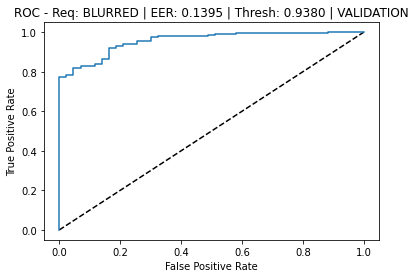

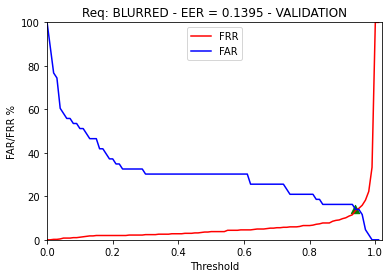

Requisite: BLURRED - EER_interp: 13.950000000000001% - Best Threshold: 0.9380009174346892
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.36      0.86      0.50        43
    COMPLIANT       0.99      0.87      0.92       504

     accuracy                           0.87       547
    macro avg       0.67      0.86      0.71       547
 weighted avg       0.94      0.87      0.89       547

Confusion matrix ----------------------------------------
FAR: 13.950000000000001% | FRR: 13.29% | EER_mean: 13.62% | TP: 437 | TN: 37 | FP: 6 | FN: 67
Accuracy ------------------------------------------------
Model Accuracy: 86.65%
---------------------------------------------------------
Requisite: SKIN_TONE


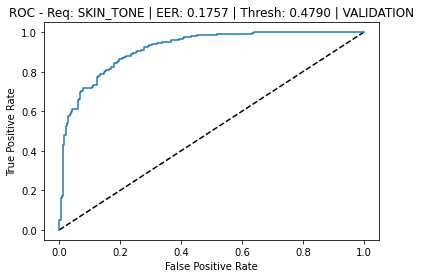

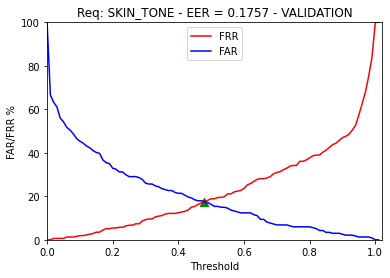

Requisite: SKIN_TONE - EER_interp: 17.57% - Best Threshold: 0.4789829602637621
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.78      0.82      0.80       234
    COMPLIANT       0.86      0.82      0.84       313

     accuracy                           0.82       547
    macro avg       0.82      0.82      0.82       547
 weighted avg       0.83      0.82      0.83       547

Confusion matrix ----------------------------------------
FAR: 17.52% | FRR: 17.57% | EER_mean: 17.54% | TP: 258 | TN: 193 | FP: 41 | FN: 55
Accuracy ------------------------------------------------
Model Accuracy: 82.45%
---------------------------------------------------------
Requisite: WASHED_OUT


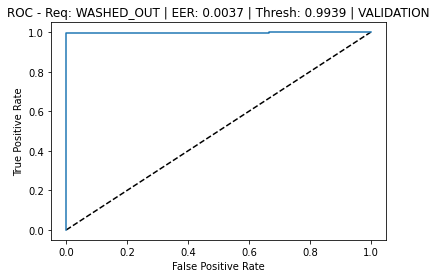

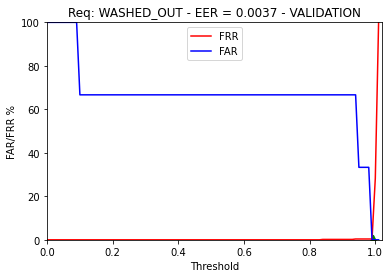

Requisite: WASHED_OUT - EER_interp: 0.37% - Best Threshold: 0.9939170308849391
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.60      1.00      0.75         3
    COMPLIANT       1.00      1.00      1.00       544

     accuracy                           1.00       547
    macro avg       0.80      1.00      0.87       547
 weighted avg       1.00      1.00      1.00       547

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 0.37% | EER_mean: 0.18% | TP: 542 | TN: 3 | FP: 0 | FN: 2
Accuracy ------------------------------------------------
Model Accuracy: 99.63%
---------------------------------------------------------
Requisite: PIXELATION


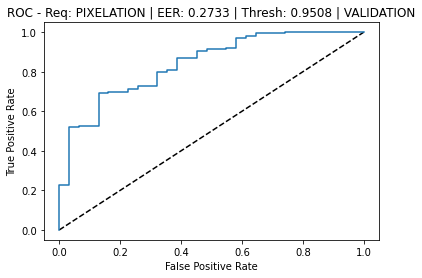

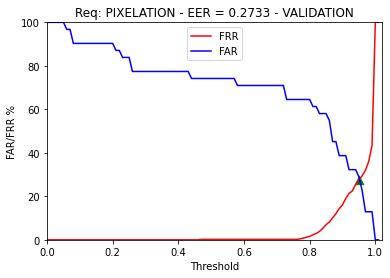

Requisite: PIXELATION - EER_interp: 27.33% - Best Threshold: 0.9507690810186918
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.14      0.74      0.24        31
    COMPLIANT       0.98      0.73      0.83       516

     accuracy                           0.73       547
    macro avg       0.56      0.73      0.54       547
 weighted avg       0.93      0.73      0.80       547

Confusion matrix ----------------------------------------
FAR: 25.81% | FRR: 27.33% | EER_mean: 26.57% | TP: 375 | TN: 23 | FP: 8 | FN: 141
Accuracy ------------------------------------------------
Model Accuracy: 72.76%
---------------------------------------------------------
Requisite: HAIR_EYES


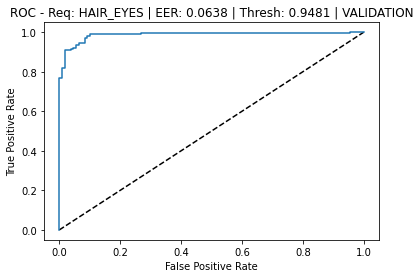

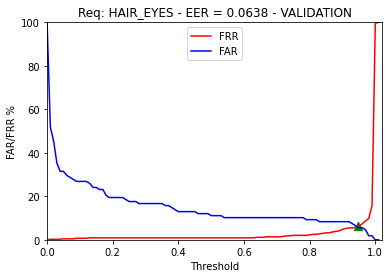

Requisite: HAIR_EYES - EER_interp: 6.38% - Best Threshold: 0.9481022672935607
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.78      0.94      0.86       108
    COMPLIANT       0.99      0.94      0.96       439

     accuracy                           0.94       547
    macro avg       0.89      0.94      0.91       547
 weighted avg       0.95      0.94      0.94       547

Confusion matrix ----------------------------------------
FAR: 5.56% | FRR: 6.38% | EER_mean: 5.970000000000001% | TP: 411 | TN: 102 | FP: 6 | FN: 28
Accuracy ------------------------------------------------
Model Accuracy: 93.78%
---------------------------------------------------------
Requisite: BACKGROUND


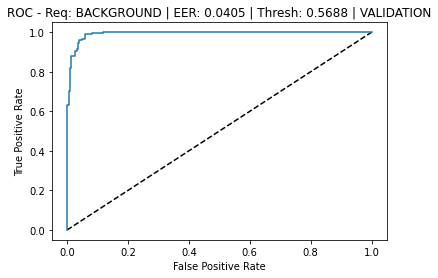

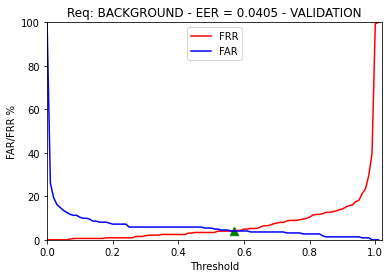

Requisite: BACKGROUND - EER_interp: 4.05% - Best Threshold: 0.5688142180393221
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.94      0.96      0.95       222
    COMPLIANT       0.97      0.96      0.97       325

     accuracy                           0.96       547
    macro avg       0.96      0.96      0.96       547
 weighted avg       0.96      0.96      0.96       547

Confusion matrix ----------------------------------------
FAR: 4.05% | FRR: 4.0% | EER_mean: 4.02% | TP: 312 | TN: 213 | FP: 9 | FN: 13
Accuracy ------------------------------------------------
Model Accuracy: 95.98%
---------------------------------------------------------
Requisite: RED_EYES


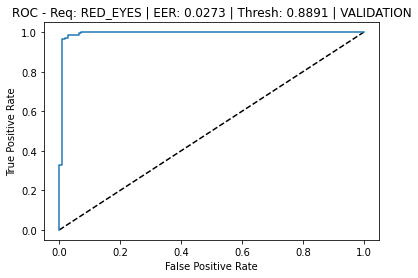

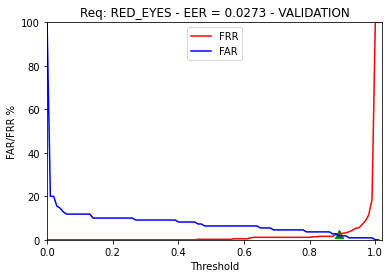

Requisite: RED_EYES - EER_interp: 2.73% - Best Threshold: 0.8891499638562351
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.90      0.97      0.93       110
    COMPLIANT       0.99      0.97      0.98       437

     accuracy                           0.97       547
    macro avg       0.95      0.97      0.96       547
 weighted avg       0.97      0.97      0.97       547

Confusion matrix ----------------------------------------
FAR: 2.73% | FRR: 2.75% | EER_mean: 2.74% | TP: 425 | TN: 107 | FP: 3 | FN: 12
Accuracy ------------------------------------------------
Model Accuracy: 97.26%
---------------------------------------------------------
final_EER_mean: 8.3% | final_ACC: 91.81%


In [16]:
runner.set_model_evaluator_data_src(DataSource.VALIDATION)
runner.test_model()

## Test Split

Testing Trained Model
Predicting labels....
9/9 [==============================] - 18s 2s/step
Prediction finished!
Requisite: MOUTH


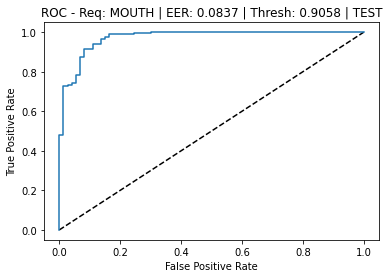

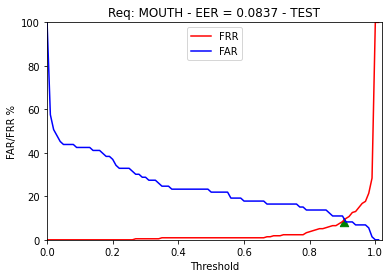

Requisite: MOUTH - EER_interp: 8.37% - Best Threshold: 0.9057787138362263
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.79      0.92      0.85        73
    COMPLIANT       0.97      0.92      0.94       215

     accuracy                           0.92       288
    macro avg       0.88      0.92      0.90       288
 weighted avg       0.92      0.92      0.92       288

Confusion matrix ----------------------------------------
FAR: 8.219999999999999% | FRR: 8.37% | EER_mean: 8.3% | TP: 197 | TN: 67 | FP: 6 | FN: 18
Accuracy ------------------------------------------------
Model Accuracy: 91.67%
---------------------------------------------------------
Requisite: ROTATION


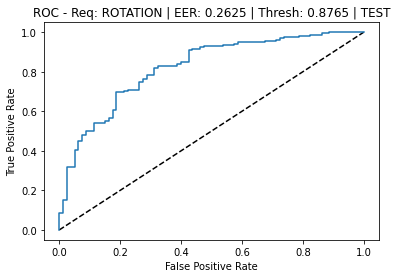

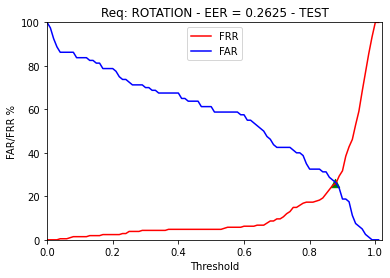

Requisite: ROTATION - EER_interp: 26.25% - Best Threshold: 0.8764889836309603
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.53      0.74      0.62        80
    COMPLIANT       0.88      0.75      0.81       208

     accuracy                           0.75       288
    macro avg       0.71      0.74      0.71       288
 weighted avg       0.78      0.75      0.76       288

Confusion matrix ----------------------------------------
FAR: 26.25% | FRR: 25.0% | EER_mean: 25.619999999999997% | TP: 156 | TN: 59 | FP: 21 | FN: 52
Accuracy ------------------------------------------------
Model Accuracy: 74.65%
---------------------------------------------------------
Requisite: L_AWAY


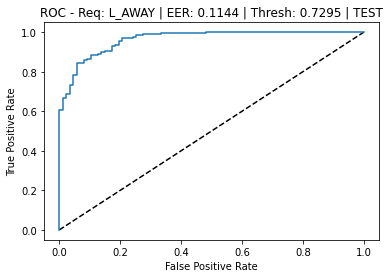

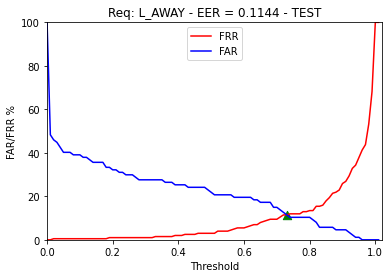

Requisite: L_AWAY - EER_interp: 11.44% - Best Threshold: 0.7295244887693221
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.77      0.89      0.82        87
    COMPLIANT       0.95      0.89      0.92       201

     accuracy                           0.89       288
    macro avg       0.86      0.89      0.87       288
 weighted avg       0.89      0.89      0.89       288

Confusion matrix ----------------------------------------
FAR: 11.49% | FRR: 11.44% | EER_mean: 11.459999999999999% | TP: 178 | TN: 77 | FP: 10 | FN: 23
Accuracy ------------------------------------------------
Model Accuracy: 88.53999999999999%
---------------------------------------------------------
Requisite: EYES_CLOSED


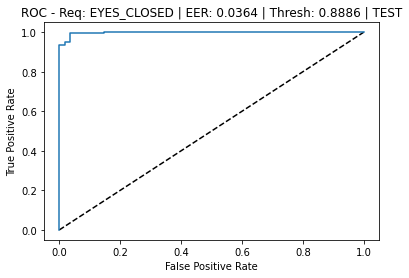

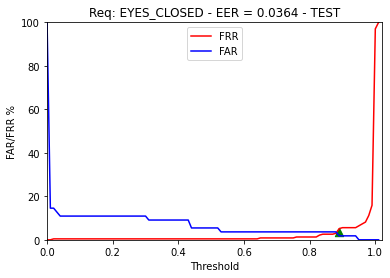

Requisite: EYES_CLOSED - EER_interp: 3.64% - Best Threshold: 0.8886213898660655
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.82      0.96      0.88        55
    COMPLIANT       0.99      0.95      0.97       233

     accuracy                           0.95       288
    macro avg       0.90      0.96      0.93       288
 weighted avg       0.96      0.95      0.95       288

Confusion matrix ----------------------------------------
FAR: 3.64% | FRR: 5.1499999999999995% | EER_mean: 4.3999999999999995% | TP: 221 | TN: 53 | FP: 2 | FN: 12
Accuracy ------------------------------------------------
Model Accuracy: 95.14%
---------------------------------------------------------
Requisite: CLOSE


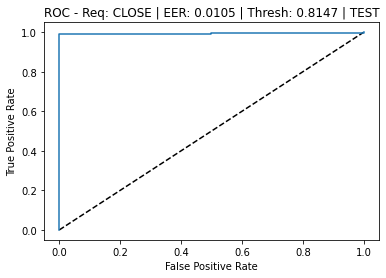

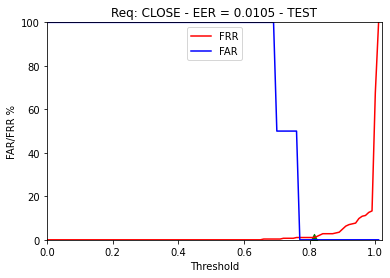

Requisite: CLOSE - EER_interp: 1.05% - Best Threshold: 0.8147218673379286
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.40      1.00      0.57         2
    COMPLIANT       1.00      0.99      0.99       286

     accuracy                           0.99       288
    macro avg       0.70      0.99      0.78       288
 weighted avg       1.00      0.99      0.99       288

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 1.05% | EER_mean: 0.52% | TP: 283 | TN: 2 | FP: 0 | FN: 3
Accuracy ------------------------------------------------
Model Accuracy: 98.96000000000001%
---------------------------------------------------------
Requisite: HAT


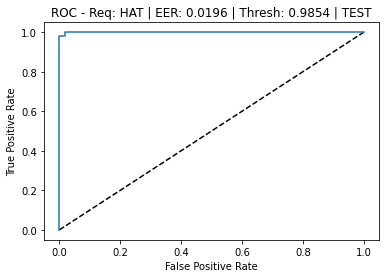

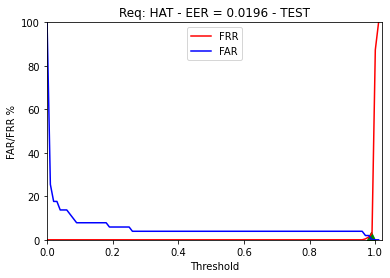

Requisite: HAT - EER_interp: 1.96% - Best Threshold: 0.9853914380074091
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.91      0.98      0.94        51
    COMPLIANT       1.00      0.98      0.99       237

     accuracy                           0.98       288
    macro avg       0.95      0.98      0.97       288
 weighted avg       0.98      0.98      0.98       288

Confusion matrix ----------------------------------------
FAR: 1.96% | FRR: 2.11% | EER_mean: 2.04% | TP: 232 | TN: 50 | FP: 1 | FN: 5
Accuracy ------------------------------------------------
Model Accuracy: 97.92%
---------------------------------------------------------
Requisite: DARK_GLASSES


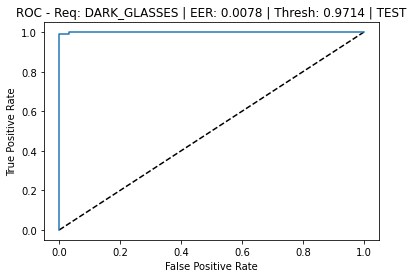

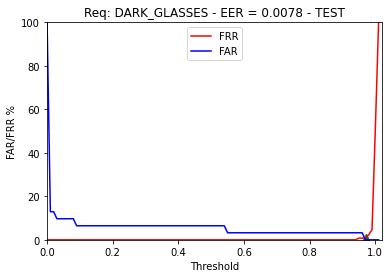

Requisite: DARK_GLASSES - EER_interp: 0.7799999999999999% - Best Threshold: 0.9713606922543006
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.94      1.00      0.97        31
    COMPLIANT       1.00      0.99      1.00       257

     accuracy                           0.99       288
    macro avg       0.97      1.00      0.98       288
 weighted avg       0.99      0.99      0.99       288

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 0.7799999999999999% | EER_mean: 0.38999999999999996% | TP: 255 | TN: 31 | FP: 0 | FN: 2
Accuracy ------------------------------------------------
Model Accuracy: 99.31%
---------------------------------------------------------
Requisite: FRAMES_HEAVY


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


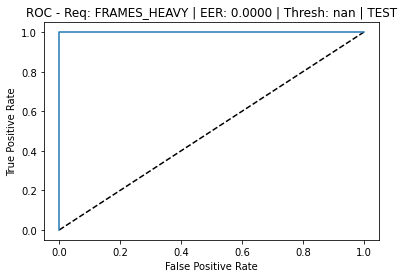

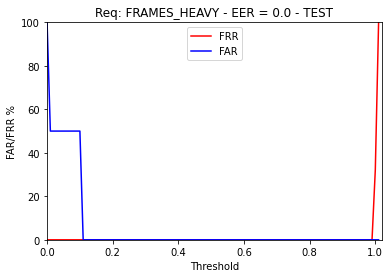

Requisite: FRAMES_HEAVY - EER_interp: 0.0% - Best Threshold: nan
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.00      0.00      0.00         2
    COMPLIANT       0.99      1.00      1.00       286

     accuracy                           0.99       288
    macro avg       0.50      0.50      0.50       288
 weighted avg       0.99      0.99      0.99       288

Confusion matrix ----------------------------------------
FAR: 100.0% | FRR: 0.0% | EER_mean: 50.0% | TP: 286 | TN: 0 | FP: 2 | FN: 0
Accuracy ------------------------------------------------
Model Accuracy: 99.31%
---------------------------------------------------------
Requisite: FRAME_EYES


/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


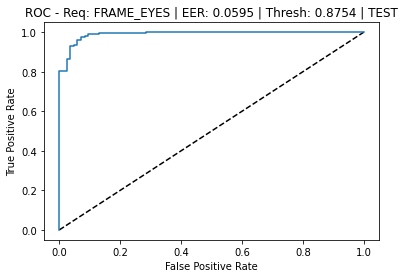

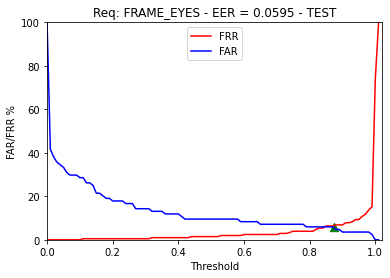

Requisite: FRAME_EYES - EER_interp: 5.949999999999999% - Best Threshold: 0.8753833770752242
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.86      0.94      0.90        84
    COMPLIANT       0.97      0.94      0.96       204

     accuracy                           0.94       288
    macro avg       0.92      0.94      0.93       288
 weighted avg       0.94      0.94      0.94       288

Confusion matrix ----------------------------------------
FAR: 5.949999999999999% | FRR: 6.370000000000001% | EER_mean: 6.16% | TP: 191 | TN: 79 | FP: 5 | FN: 13
Accuracy ------------------------------------------------
Model Accuracy: 93.75%
---------------------------------------------------------
Requisite: FLASH_LENSES


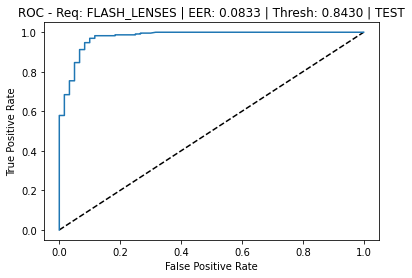

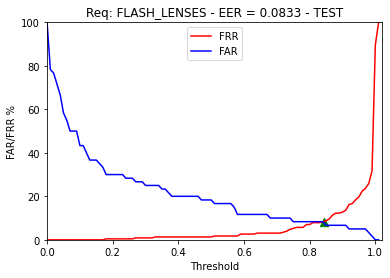

Requisite: FLASH_LENSES - EER_interp: 8.33% - Best Threshold: 0.8430418372156945
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.73      0.92      0.81        60
    COMPLIANT       0.98      0.91      0.94       228

     accuracy                           0.91       288
    macro avg       0.85      0.91      0.88       288
 weighted avg       0.93      0.91      0.92       288

Confusion matrix ----------------------------------------
FAR: 8.33% | FRR: 8.77% | EER_mean: 8.55% | TP: 208 | TN: 55 | FP: 5 | FN: 20
Accuracy ------------------------------------------------
Model Accuracy: 91.32000000000001%
---------------------------------------------------------
Requisite: VEIL


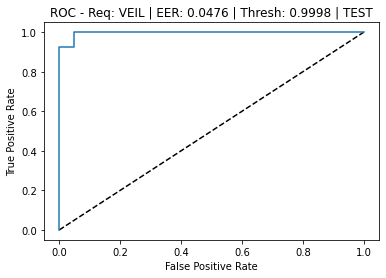

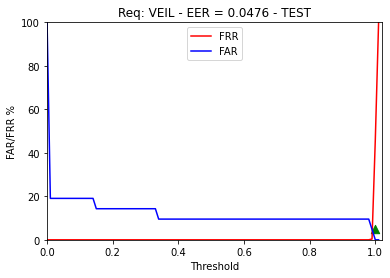

Requisite: VEIL - EER_interp: 4.760000000000001% - Best Threshold: 0.9997521042823792
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.50      0.95      0.66        21
    COMPLIANT       1.00      0.93      0.96       267

     accuracy                           0.93       288
    macro avg       0.75      0.94      0.81       288
 weighted avg       0.96      0.93      0.94       288

Confusion matrix ----------------------------------------
FAR: 4.760000000000001% | FRR: 7.489999999999999% | EER_mean: 6.12% | TP: 247 | TN: 20 | FP: 1 | FN: 20
Accuracy ------------------------------------------------
Model Accuracy: 92.71000000000001%
---------------------------------------------------------
Requisite: REFLECTION


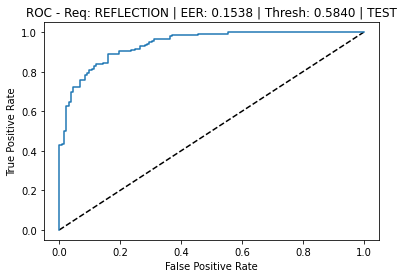

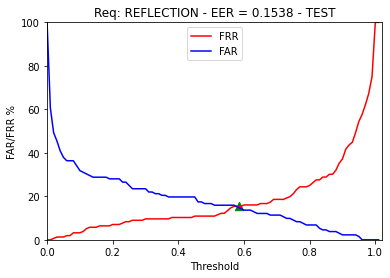

Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.


Requisite: REFLECTION - EER_interp: 15.379999999999999% - Best Threshold: 0.5840439292100236
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.82      0.86      0.84       132
    COMPLIANT       0.87      0.85      0.86       156

     accuracy                           0.85       288
    macro avg       0.85      0.85      0.85       288
 weighted avg       0.85      0.85      0.85       288

Confusion matrix ----------------------------------------
FAR: 14.39% | FRR: 15.379999999999999% | EER_mean: 14.879999999999999% | TP: 132 | TN: 113 | FP: 19 | FN: 24
Accuracy ------------------------------------------------
Model Accuracy: 85.07000000000001%
---------------------------------------------------------
Requisite: LIGHT


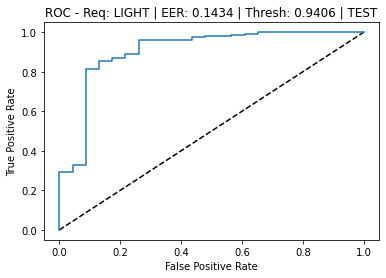

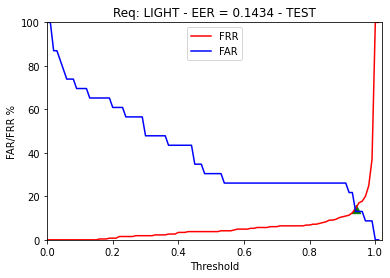

Requisite: LIGHT - EER_interp: 14.34% - Best Threshold: 0.9405852549480942
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.34      0.87      0.49        23
    COMPLIANT       0.99      0.86      0.92       265

     accuracy                           0.86       288
    macro avg       0.67      0.86      0.71       288
 weighted avg       0.94      0.86      0.88       288

Confusion matrix ----------------------------------------
FAR: 13.04% | FRR: 14.34% | EER_mean: 13.69% | TP: 227 | TN: 20 | FP: 3 | FN: 38
Accuracy ------------------------------------------------
Model Accuracy: 85.76%
---------------------------------------------------------
Requisite: SH_FACE


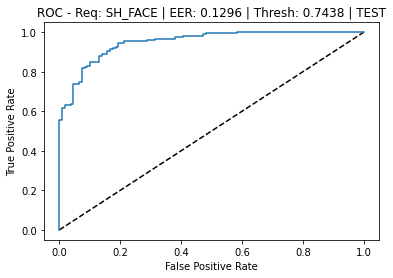

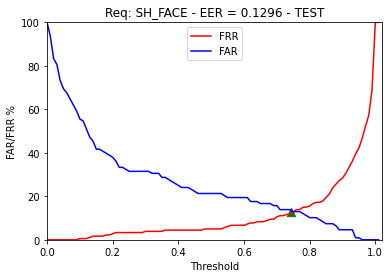

Requisite: SH_FACE - EER_interp: 12.959999999999999% - Best Threshold: 0.7438153624533784
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.81      0.87      0.84       108
    COMPLIANT       0.92      0.88      0.90       180

     accuracy                           0.88       288
    macro avg       0.86      0.87      0.87       288
 weighted avg       0.88      0.88      0.88       288

Confusion matrix ----------------------------------------
FAR: 12.959999999999999% | FRR: 12.22% | EER_mean: 12.590000000000002% | TP: 158 | TN: 94 | FP: 14 | FN: 22
Accuracy ------------------------------------------------
Model Accuracy: 87.5%
---------------------------------------------------------
Requisite: SH_HEAD


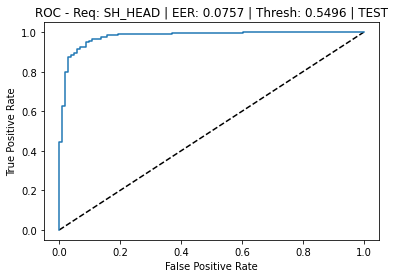

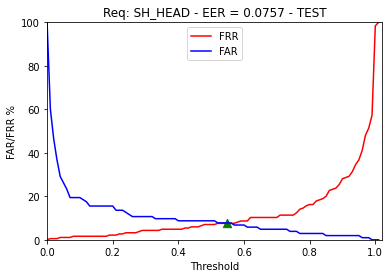

Requisite: SH_HEAD - EER_interp: 7.57% - Best Threshold: 0.549626034820402
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.87      0.92      0.90       103
    COMPLIANT       0.96      0.92      0.94       185

     accuracy                           0.92       288
    macro avg       0.91      0.92      0.92       288
 weighted avg       0.93      0.92      0.92       288

Confusion matrix ----------------------------------------
FAR: 7.7700000000000005% | FRR: 7.57% | EER_mean: 7.670000000000001% | TP: 171 | TN: 95 | FP: 8 | FN: 14
Accuracy ------------------------------------------------
Model Accuracy: 92.36%
---------------------------------------------------------
Requisite: BLURRED


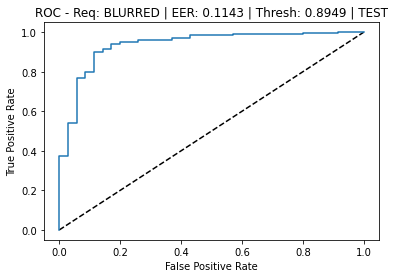

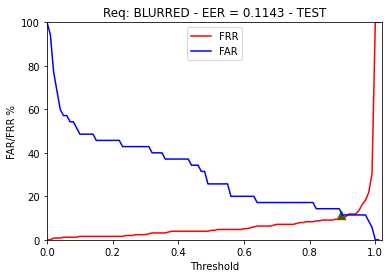

Requisite: BLURRED - EER_interp: 11.43% - Best Threshold: 0.8949282169341888
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.55      0.89      0.68        35
    COMPLIANT       0.98      0.90      0.94       253

     accuracy                           0.90       288
    macro avg       0.77      0.89      0.81       288
 weighted avg       0.93      0.90      0.91       288

Confusion matrix ----------------------------------------
FAR: 11.43% | FRR: 9.879999999999999% | EER_mean: 10.66% | TP: 228 | TN: 31 | FP: 4 | FN: 25
Accuracy ------------------------------------------------
Model Accuracy: 89.92999999999999%
---------------------------------------------------------
Requisite: SKIN_TONE


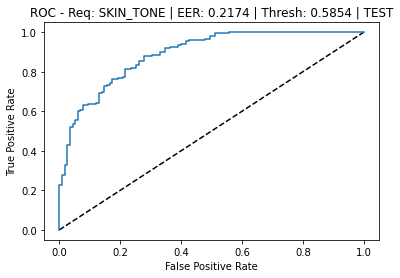

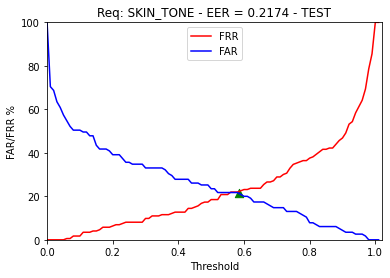

Requisite: SKIN_TONE - EER_interp: 21.740000000000002% - Best Threshold: 0.5854498147970277
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.70      0.78      0.74       115
    COMPLIANT       0.84      0.77      0.81       173

     accuracy                           0.78       288
    macro avg       0.77      0.78      0.77       288
 weighted avg       0.78      0.78      0.78       288

Confusion matrix ----------------------------------------
FAR: 21.740000000000002% | FRR: 22.54% | EER_mean: 22.14% | TP: 134 | TN: 90 | FP: 25 | FN: 39
Accuracy ------------------------------------------------
Model Accuracy: 77.78%
---------------------------------------------------------
Requisite: WASHED_OUT


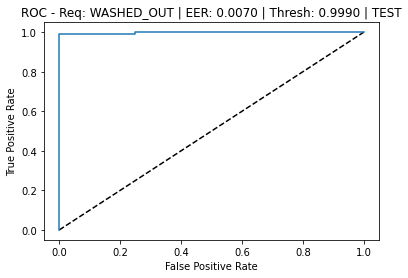

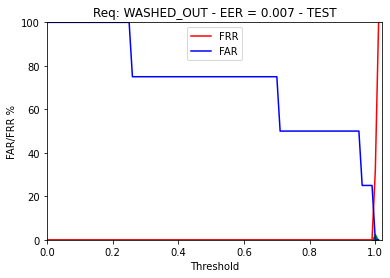

Requisite: WASHED_OUT - EER_interp: 0.7000000000000001% - Best Threshold: 0.9990340538427863
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.67      1.00      0.80         4
    COMPLIANT       1.00      0.99      1.00       284

     accuracy                           0.99       288
    macro avg       0.83      1.00      0.90       288
 weighted avg       1.00      0.99      0.99       288

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 0.7000000000000001% | EER_mean: 0.35000000000000003% | TP: 282 | TN: 4 | FP: 0 | FN: 2
Accuracy ------------------------------------------------
Model Accuracy: 99.31%
---------------------------------------------------------
Requisite: PIXELATION


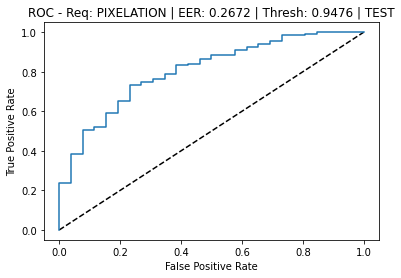

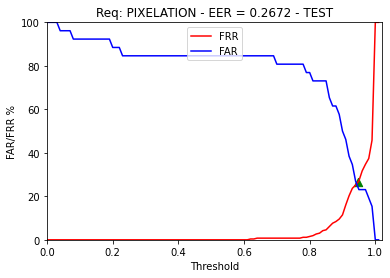

Requisite: PIXELATION - EER_interp: 26.72% - Best Threshold: 0.9476275302981649
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.22      0.77      0.34        26
    COMPLIANT       0.97      0.73      0.83       262

     accuracy                           0.74       288
    macro avg       0.60      0.75      0.59       288
 weighted avg       0.90      0.74      0.79       288

Confusion matrix ----------------------------------------
FAR: 23.080000000000002% | FRR: 26.72% | EER_mean: 24.9% | TP: 192 | TN: 20 | FP: 6 | FN: 70
Accuracy ------------------------------------------------
Model Accuracy: 73.61%
---------------------------------------------------------
Requisite: HAIR_EYES


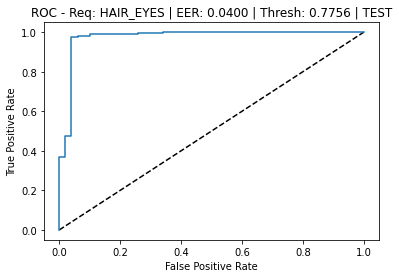

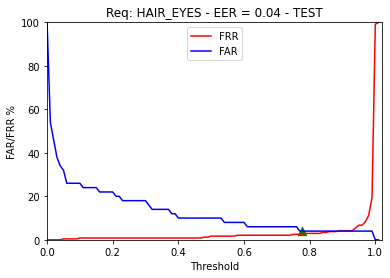

Requisite: HAIR_EYES - EER_interp: 4.0% - Best Threshold: 0.7756331562994888
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.89      0.96      0.92        50
    COMPLIANT       0.99      0.97      0.98       238

     accuracy                           0.97       288
    macro avg       0.94      0.97      0.95       288
 weighted avg       0.97      0.97      0.97       288

Confusion matrix ----------------------------------------
FAR: 4.0% | FRR: 2.52% | EER_mean: 3.26% | TP: 232 | TN: 48 | FP: 2 | FN: 6
Accuracy ------------------------------------------------
Model Accuracy: 97.22%
---------------------------------------------------------
Requisite: BACKGROUND


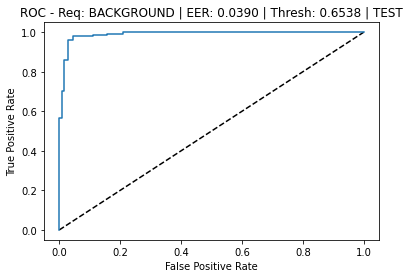

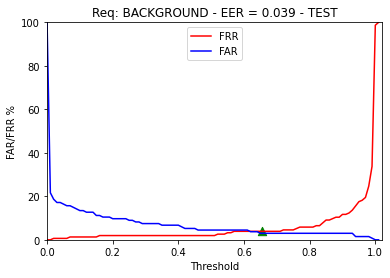

Requisite: BACKGROUND - EER_interp: 3.9% - Best Threshold: 0.6537789152829825
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.96      0.97      0.96       134
    COMPLIANT       0.97      0.96      0.97       154

     accuracy                           0.97       288
    macro avg       0.96      0.97      0.97       288
 weighted avg       0.97      0.97      0.97       288

Confusion matrix ----------------------------------------
FAR: 2.9899999999999998% | FRR: 3.9% | EER_mean: 3.44% | TP: 148 | TN: 130 | FP: 4 | FN: 6
Accuracy ------------------------------------------------
Model Accuracy: 96.53%
---------------------------------------------------------
Requisite: RED_EYES


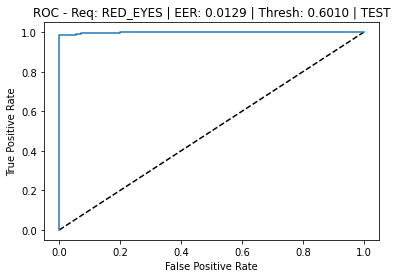

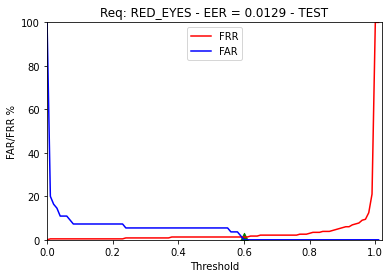

Requisite: RED_EYES - EER_interp: 1.29% - Best Threshold: 0.601020963406936
Classification report -----------------------------------
               precision    recall  f1-score   support

NON_COMPLIANT       0.95      1.00      0.97        55
    COMPLIANT       1.00      0.99      0.99       233

     accuracy                           0.99       288
    macro avg       0.97      0.99      0.98       288
 weighted avg       0.99      0.99      0.99       288

Confusion matrix ----------------------------------------
FAR: 0.0% | FRR: 1.29% | EER_mean: 0.64% | TP: 230 | TN: 55 | FP: 0 | FN: 3
Accuracy ------------------------------------------------
Model Accuracy: 98.96000000000001%
---------------------------------------------------------
final_EER_mean: 10.81% | final_ACC: 91.24%


In [17]:
runner.set_model_evaluator_data_src(DataSource.TEST)
runner.test_model()

# Visualize Model Classification

# Finishing Experiment Manager

In [18]:
runner.finish_experiment()

-------------------- finish experiment -------------------
Finishing Neptune


# Testing Network Modification